In [1]:
import os
import ccdproc
import numpy as np
# import astroalign as aa
import astropy.units as u
import astropy.io.fits as pyfits

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def filelist(path):
    
    filename_list = [path + file for file in os.listdir(path)\
                     if file.endswith('.fits')]
    
    if filename_list:
        filename_list.sort()
        
    return filename_list

This function creates a list of file names using the variables `path`(the folder) and `file`(the file) providing the file has a `.fits` extension.

It then sorts the file names and returns the sorted list.

In [4]:
def filter_checker(filelist):

    images = {}
    
    for file in filelist:
        hdulist = pyfits.open(file)
        image = pyfits.getdata(file)
    
        if (hdulist[0].header['INSFLNUM'] == 2):
            images.setdefault('B', []).append(image)
        
        elif (hdulist[0].header['INSFLNUM'] == 3):
            images.setdefault('V', []).append(image)
        
        elif (hdulist[0].header['INSFLNUM'] == 6):
            images.setdefault('Ha', []).append(image)
        
        else: # print warning for any addiotional filters used
            print('Additional filter found: '\
                  + str(hdulist[0].header['INSFLNUM'])\
                 + ' - ' + str(file))
    
        hdulist.close()
    
    return images

This function checks which filter was used on the apparatus to capture the light.

In [5]:
def opener(filename_list):
    
    images = []
    
    for file in filename_list:
        images.append(pyfits.getdata(file))
        
    return images

In [6]:
def trim(image_list):
    
    trim = np.arange(0, 8, 1)
    trimmed = []

    for image in image_list:
#         img = pyfits.getdata(image, 0)
        trimmed.append(np.delete(image, trim, 0))
    
    return trimmed

This function takes the list of image filenames, `filename_list`, loads each image using `pf.getdata` and trims the first 8 columns from the image and returns the trimmed image.

In [7]:
def master_image(image_list):      
    
    imagecube = np.array(image_list)
    master_image = np.median(imagecube, axis=0)
    
    return master_image

This function receives the list of sourced and trimmed images, `image_list`. 

This list is then flattened into `imagecube` and a master created by taking its median and assigning it to `master_image`.

`master_image` is then returned.

In [8]:
def master_flat(flat):
    
    trimmed_flats = trim(flat)
    master_flats = master_image(trimmed_flats)
    # normalising
    master_flats = master_flats / np.mean(master_flats)
    master_flats = ccdproc.CCDData(master_flats, unit=u.adu)
    
    return master_flats

This function generates master flat images by first trimming the image using `trim`, then uses `master_image` to make the master flat then uses `ccdproc` to convert to ADU.

In [9]:
def master_object(target, flat, bias):
    
    reduced_target = []
    trimmed_target = trim(target)
    
    for img in trimmed_target:
        data = ccdproc.CCDData(img, unit=u.adu)

        bias_subtracted = ccdproc.subtract_bias(data, bias)
        flat_corrected = ccdproc.flat_correct(bias_subtracted, flat)
        
        reduced_target.append(flat_corrected)
#     reduced_master = master_image(flat_corrected)
    
    return reduced_target

This function works in a similar manner to `master_flat` but with the added functionality to subtract the master bias image and perform flat correction using the master flat image as well as aligning the images before stacking.

## Bias

In [11]:
path = '../calor_alto_data/bias/'

In [12]:
bias = filelist(path)
biases = opener(bias)

trimmed_bias = trim(biases)
master_bias = master_image(trimmed_bias)
master_bias = ccdproc.CCDData(master_bias, unit=u.adu)

The cells above first set the `path` variable, then call the `bias` function using this path, then call the `trim` function on each image in the bias list, then call the `master_image` function on these trimmed images. The final line converts the `master_bias` to adu.

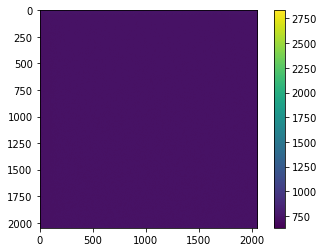

In [13]:
plt.imshow(trimmed_bias[0])
plt.colorbar()

In [14]:
hdu_bias = pyfits.PrimaryHDU(master_bias)
hdu_bias.writeto('../reduced_images/bias.fits',
#                  header = bias_header,
                 overwrite=True
                )

In [15]:
del bias
del biases
del trimmed_bias
del master_bias

## Flats

In [16]:
path_2 = '../calor_alto_data/'

In [17]:
flat_Ha = filelist(str(path_2 + 'Ha_flats/'))
flat_V = filelist(str(path_2 + 'V_flats/'))
flat_B = filelist(str(path_2 + 'B_flats/'))

flats_Ha = opener(flat_Ha)
flats_V = opener(flat_V)
flats_B = opener(flat_B)
# flat_dict = filter_checker(flat)

master_Ha_flat = master_flat(flats_Ha)#flat_dict["B"])
master_V_flat = master_flat(flats_V)#flat_dict["V"])
master_B_flat = master_flat(flats_B)#flat_dict["Ha"])

This cell the master flat images using the `master_flat` function.

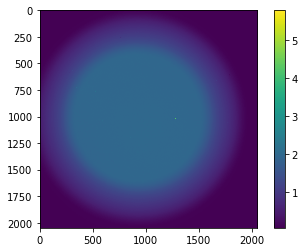

In [18]:
plt.imshow(master_Ha_flat)
plt.colorbar()

In [19]:
hdu_B_flat = pyfits.PrimaryHDU(master_B_flat)
hdu_B_flat.writeto('../reduced_images/B_flat.fits',
#                    header = B_flat_header,
                   overwrite=True
                  )

hdu_V_flat = pyfits.PrimaryHDU(master_V_flat)
hdu_V_flat.writeto('../reduced_images/V_flat.fits',
#                    header = V_flat_header,
                   overwrite=True
                  )

hdu_Ha_flat = pyfits.PrimaryHDU(master_Ha_flat)
hdu_Ha_flat.writeto('../reduced_images/Ha_flat.fits',
#                     header = Ha_flat_header,
                    overwrite=True
                   )

In [20]:
del flat_Ha
del flat_V
del flat_B

del flats_Ha
del flats_V
del flats_B

del master_Ha_flat
del master_V_flat
del master_B_flat

## Object

In [10]:
path_3 = '../calor_alto_data/NGC6720/'

In [11]:
target = filelist(path_3)
target_dict = filter_checker(target)

In [12]:
bias = pyfits.getdata('../reduced_images/bias.fits')
bias  = ccdproc.CCDData(bias, unit=u.adu)

### B filter

In [45]:
flat = pyfits.getdata('../reduced_images/B_flat.fits')
flat = ccdproc.CCDData(flat, unit=u.adu)

In [46]:
reduced_B_image = master_object(target_dict["B"], flat, bias)

In [47]:
for i in range(len(reduced_B_image)):
    hdu_B = pyfits.PrimaryHDU(reduced_B_image[i])
    filename = '../reduced_images/target/B_reduced_' + str(i+1) + '.fits'
    hdu_B.writeto(filename, overwrite=True)

In [48]:
del reduced_B_image
del flat

### V filter

In [49]:
flat = pyfits.getdata('../reduced_images/V_flat.fits')
flat = ccdproc.CCDData(flat, unit=u.adu)

reduced_V_image = master_object(target_dict["V"], flat, bias)

In [50]:
for i in range(len(reduced_V_image)):
    hdu_V = pyfits.PrimaryHDU(reduced_V_image[i])
    filename = '../reduced_images/target/V_reduced_' + str(i+1) + '.fits'
    hdu_V.writeto(filename, overwrite=True)

In [51]:
del reduced_V_image
del flat

### H$_{\mathbf{\alpha}}$ filter

In [52]:
flat = pyfits.getdata('../reduced_images/Ha_flat.fits')
flat = ccdproc.CCDData(flat, unit=u.adu)

reduced_Ha_image = master_object(target_dict["Ha"], flat, bias)

In [53]:
for i in range(len(reduced_Ha_image)):
    hdu_Ha = pyfits.PrimaryHDU(reduced_Ha_image[i])
    filename = '../reduced_images/target/Ha_reduced_' + str(i+1) + '.fits'
    hdu_Ha.writeto(filename, overwrite=True)

In [54]:
del reduced_Ha_image
del flat

The above cells generate reduced images for each flter using the `master_object` function which in turn uses the previously generated master bias and master flat images.